# ベーシックステップ第2回課題
不動産の売上予測

In [1]:
#ライブラリインポート
%matplotlib inline
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import scipy as sp
from scipy import stats
from scipy.stats import spearmanr

import psycopg2
from pandas import DataFrame
from __future__ import print_function

#xgboostをインポート
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold

#Scikit-learnをインポート
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# データのインポート

In [2]:
#学習データのインポート
train_data = pd.read_csv('dataset/train.csv')

In [3]:
#実際のデータのインポート
test_data = pd.read_csv('dataset/test.csv')

特徴量の特徴を検討

In [4]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


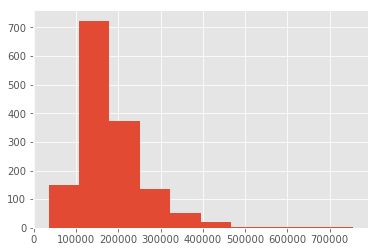

In [5]:
#データの分布（ヒストグラム）
train_data['SalePrice'].hist()

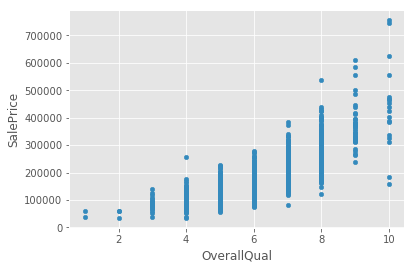

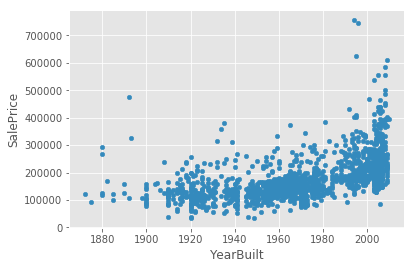

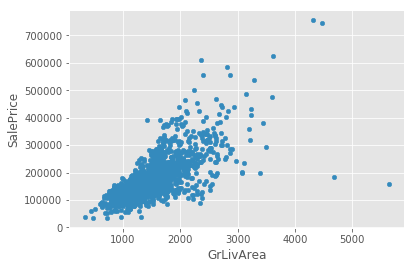

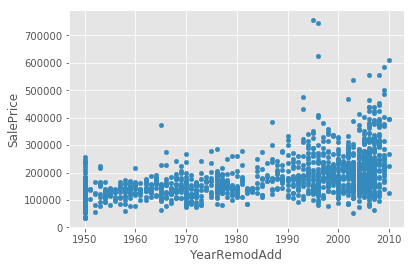

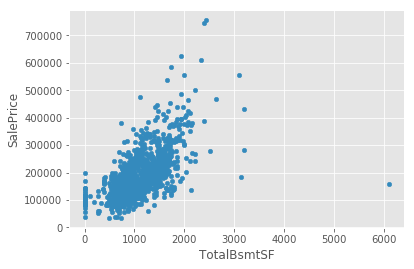

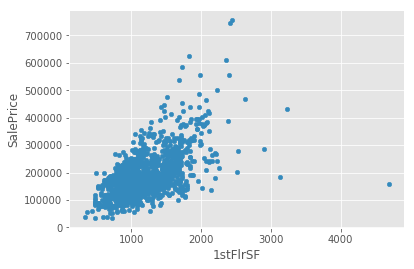

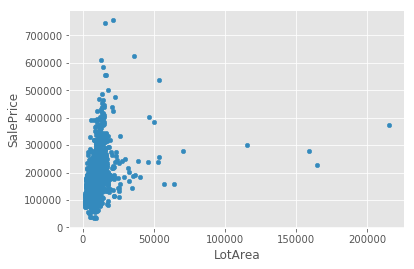

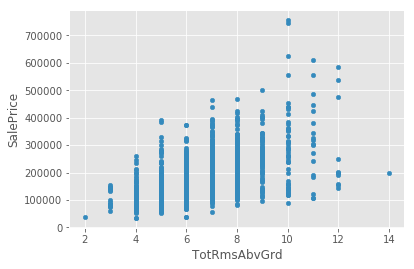

In [6]:
#データの相関性（散布図）
train_data.plot(kind='scatter', x='OverallQual', y='SalePrice')
train_data.plot(kind='scatter', x='YearBuilt', y='SalePrice')
train_data.plot(kind='scatter', x='GrLivArea', y='SalePrice')
train_data.plot(kind='scatter', x='YearRemodAdd', y='SalePrice')
train_data.plot(kind='scatter', x='TotalBsmtSF', y='SalePrice')
#train_data.plot(kind='scatter', x='BsmtQual', y='SalePrice')
train_data.plot(kind='scatter', x='1stFlrSF', y='SalePrice')
train_data.plot(kind='scatter', x='LotArea', y='SalePrice')
train_data.plot(kind='scatter', x='TotRmsAbvGrd', y='SalePrice')

# 学習データの前処理

In [7]:
#ターゲット変数と説明変数の設定
target_col = 'SalePrice'
exclude_cols = ['']
feature_cols = [col for col in train_data.columns if col not in exclude_cols]

#説明変数のデータ
y_train = train_data[target_col]
x_train = train_data[feature_cols]

In [8]:

#説明変数の置換
x_train['MSSubClass'] = x_train['MSSubClass'].replace(np.NaN,0)
x_train['LotFrontage'] = x_train['LotFrontage'].replace(np.NaN,0)
x_train['LotArea'] = x_train['LotArea'].replace(np.NaN,0)
x_train['OverallQual'] = x_train['OverallQual'].replace(np.NaN,0)
x_train['OverallCond'] = x_train['OverallCond'].replace(np.NaN,0)
x_train['YearBuilt'] = x_train['YearBuilt'].replace(np.NaN,0)
x_train['YearRemodAdd'] = x_train['YearRemodAdd'].replace(np.NaN,0)
x_train['MasVnrArea'] = x_train['MasVnrArea'].replace(np.NaN,0)
x_train['BsmtFinSF1'] = x_train['BsmtFinSF1'].replace(np.NaN,0)
x_train['BsmtFinSF2'] = x_train['BsmtFinSF2'].replace(np.NaN,0)
x_train['BsmtUnfSF'] = x_train['BsmtUnfSF'].replace(np.NaN,0)
x_train['TotalBsmtSF'] = x_train['TotalBsmtSF'].replace(np.NaN,0)
x_train['1stFlrSF'] = x_train['1stFlrSF'].replace(np.NaN,0)
x_train['2ndFlrSF'] = x_train['2ndFlrSF'].replace(np.NaN,0)
x_train['LowQualFinSF'] = x_train['LowQualFinSF'].replace(np.NaN,0)
x_train['GrLivArea'] = x_train['GrLivArea'].replace(np.NaN,0)
x_train['BsmtFullBath'] = x_train['BsmtFullBath'].replace(np.NaN,0)
x_train['BsmtHalfBath'] = x_train['BsmtHalfBath'].replace(np.NaN,0)
x_train['FullBath'] = x_train['FullBath'].replace(np.NaN,0)
x_train['HalfBath'] = x_train['HalfBath'].replace(np.NaN,0)
x_train['BedroomAbvGr'] = x_train['BedroomAbvGr'].replace(np.NaN,0)
x_train['KitchenAbvGr'] = x_train['KitchenAbvGr'].replace(np.NaN,0)
x_train['TotRmsAbvGrd'] = x_train['TotRmsAbvGrd'].replace(np.NaN,0)
x_train['Fireplaces'] = x_train['Fireplaces'].replace(np.NaN,0)
x_train['GarageYrBlt'] = x_train['GarageYrBlt'].replace(np.NaN,0)
x_train['GarageCars'] = x_train['GarageCars'].replace(np.NaN,0)
x_train['GarageArea'] = x_train['GarageArea'].replace(np.NaN,0)
x_train['WoodDeckSF'] = x_train['WoodDeckSF'].replace(np.NaN,0)
x_train['OpenPorchSF'] = x_train['OpenPorchSF'].replace(np.NaN,0)
x_train['EnclosedPorch'] = x_train['EnclosedPorch'].replace(np.NaN,0)
x_train['3SsnPorch'] = x_train['3SsnPorch'].replace(np.NaN,0)
x_train['ScreenPorch'] = x_train['ScreenPorch'].replace(np.NaN,0)
x_train['PoolArea'] = x_train['PoolArea'].replace(np.NaN,0)
x_train['MiscVal'] = x_train['MiscVal'].replace(np.NaN,0)
x_train['MoSold'] = x_train['MoSold'].replace(np.NaN,0)
x_train['YrSold'] = x_train['YrSold'].replace(np.NaN,0)

In [9]:
#一部の変数をランキング化
def ranking(d):
    if d == 'Ex':
        return 5
    elif d == 'Gd':
        return 4
    elif d == 'TA':
        return 3
    elif d == 'Fa':
        return 2
    elif d == 'Po':
        return 1
    else:
        return 0

In [10]:
#変数をランキング化
x_train['ExterQual_rank'] = 0
x_train['ExterCond_rank'] = 0
x_train['BsmtQual_rank'] = 0
x_train['BsmtCond_rank'] = 0
x_train['BsmtExposure_rank'] = 0
x_train['HeatingQC_rank'] = 0
x_train['KitchenQual_rank'] = 0
x_train['FireplaceQu_rank'] = 0
x_train['GarageQual_rank'] = 0
x_train['GarageCond_rank'] = 0
x_train['PoolQC_rank'] = 0

for i in x_train.index:
    x_train['ExterQual_rank'].iloc[i] = ranking(x_train['ExterQual'].iloc[i])
    x_train['ExterCond_rank'].iloc[i] = ranking(x_train['ExterCond'].iloc[i])
    x_train['BsmtQual_rank'].iloc[i] = ranking(x_train['BsmtQual'].iloc[i])
    x_train['BsmtCond_rank'].iloc[i] = ranking(x_train['BsmtCond'].iloc[i])
    x_train['BsmtExposure_rank'].iloc[i] = ranking(x_train['BsmtExposure'].iloc[i])
    x_train['HeatingQC_rank'].iloc[i] = ranking(x_train['HeatingQC'].iloc[i])
    x_train['KitchenQual_rank'].iloc[i] = ranking(x_train['KitchenQual'].iloc[i])
    x_train['FireplaceQu_rank'].iloc[i] = ranking(x_train['FireplaceQu'].iloc[i])
    x_train['GarageQual_rank'].iloc[i] = ranking(x_train['GarageQual'].iloc[i])
    x_train['GarageCond_rank'].iloc[i] = ranking(x_train['GarageCond'].iloc[i])
    x_train['PoolQC_rank'].iloc[i] = ranking(x_train['PoolQC'].iloc[i])

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
#ランキング化した変数のドロップ
x_train = x_train.drop(['ExterQual'], axis=1)
x_train = x_train.drop(['ExterCond'], axis=1)
x_train = x_train.drop(['BsmtQual'], axis=1)
x_train = x_train.drop(['BsmtCond'], axis=1)
x_train = x_train.drop(['BsmtExposure'], axis=1)
x_train = x_train.drop(['HeatingQC'], axis=1)
x_train = x_train.drop(['KitchenQual'], axis=1)
x_train = x_train.drop(['FireplaceQu'], axis=1)
x_train = x_train.drop(['GarageQual'], axis=1)
x_train = x_train.drop(['GarageCond'], axis=1)
x_train = x_train.drop(['PoolQC'], axis=1)

In [12]:
# カテゴリ変数のダミー変数作成
colnames_categorical = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','BsmtFinType1','BsmtFinType2','Heating','CentralAir','Electrical','Functional','GarageType','GarageFinish','PavedDrive','Fence','MiscFeature','SaleType','SaleCondition']
x_train_dummy = pd.get_dummies(x_train[colnames_categorical], drop_first=True)

# ダミー変数の結合
x_train = pd.merge(x_train, x_train_dummy, left_index=True, right_index=True)

In [13]:
# 使わない、重複している列の削除
x_train = x_train.drop(colnames_categorical, axis=1)
x_train = x_train.drop(['Id'], axis=1)

feature2_cols = [col for col in x_train.columns if col not in target_col]
x_train = x_train[feature2_cols]

In [14]:
x_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


# テストデータの前処理

In [15]:
#ターゲット変数と説明変数の設定
exclude_cols = ['']
feature_cols = [col for col in test_data.columns if col not in exclude_cols]

#説明変数のデータ
x_test = test_data[feature_cols]

In [17]:
#説明変数の置換
x_test['MSSubClass'] = x_test['MSSubClass'].replace(np.NaN,0)
x_test['LotFrontage'] = x_test['LotFrontage'].replace(np.NaN,0)
x_test['LotArea'] = x_test['LotArea'].replace(np.NaN,0)
x_test['OverallQual'] = x_test['OverallQual'].replace(np.NaN,0)
x_test['OverallCond'] = x_test['OverallCond'].replace(np.NaN,0)
x_test['YearBuilt'] = x_test['YearBuilt'].replace(np.NaN,0)
x_test['YearRemodAdd'] = x_test['YearRemodAdd'].replace(np.NaN,0)
x_test['MasVnrArea'] = x_test['MasVnrArea'].replace(np.NaN,0)
x_test['BsmtFinSF1'] = x_test['BsmtFinSF1'].replace(np.NaN,0)
x_test['BsmtFinSF2'] = x_test['BsmtFinSF2'].replace(np.NaN,0)
x_test['BsmtUnfSF'] = x_test['BsmtUnfSF'].replace(np.NaN,0)
x_test['TotalBsmtSF'] = x_test['TotalBsmtSF'].replace(np.NaN,0)
x_test['1stFlrSF'] = x_test['1stFlrSF'].replace(np.NaN,0)
x_test['2ndFlrSF'] = x_test['2ndFlrSF'].replace(np.NaN,0)
x_test['LowQualFinSF'] = x_test['LowQualFinSF'].replace(np.NaN,0)
x_test['GrLivArea'] = x_test['GrLivArea'].replace(np.NaN,0)
x_test['BsmtFullBath'] = x_test['BsmtFullBath'].replace(np.NaN,0)
x_test['BsmtHalfBath'] = x_test['BsmtHalfBath'].replace(np.NaN,0)
x_test['FullBath'] = x_test['FullBath'].replace(np.NaN,0)
x_test['HalfBath'] = x_test['HalfBath'].replace(np.NaN,0)
x_test['BedroomAbvGr'] = x_test['BedroomAbvGr'].replace(np.NaN,0)
x_test['KitchenAbvGr'] = x_test['KitchenAbvGr'].replace(np.NaN,0)
x_test['TotRmsAbvGrd'] = x_test['TotRmsAbvGrd'].replace(np.NaN,0)
x_test['Fireplaces'] = x_test['Fireplaces'].replace(np.NaN,0)
x_test['GarageYrBlt'] = x_test['GarageYrBlt'].replace(np.NaN,0)
x_test['GarageCars'] = x_test['GarageCars'].replace(np.NaN,0)
x_test['GarageArea'] = x_test['GarageArea'].replace(np.NaN,0)
x_test['WoodDeckSF'] = x_test['WoodDeckSF'].replace(np.NaN,0)
x_test['OpenPorchSF'] = x_test['OpenPorchSF'].replace(np.NaN,0)
x_test['EnclosedPorch'] = x_test['EnclosedPorch'].replace(np.NaN,0)
x_test['3SsnPorch'] = x_test['3SsnPorch'].replace(np.NaN,0)
x_test['ScreenPorch'] = x_test['ScreenPorch'].replace(np.NaN,0)
x_test['PoolArea'] = x_test['PoolArea'].replace(np.NaN,0)
x_test['MiscVal'] = x_test['MiscVal'].replace(np.NaN,0)
x_test['MoSold'] = x_test['MoSold'].replace(np.NaN,0)
x_test['YrSold'] = x_test['YrSold'].replace(np.NaN,0)

In [18]:
#変数をランキング化
x_test['ExterQual_rank'] = 0
x_test['ExterCond_rank'] = 0
x_test['BsmtQual_rank'] = 0
x_test['BsmtCond_rank'] = 0
x_test['BsmtExposure_rank'] = 0
x_test['HeatingQC_rank'] = 0
x_test['KitchenQual_rank'] = 0
x_test['FireplaceQu_rank'] = 0
x_test['GarageQual_rank'] = 0
x_test['GarageCond_rank'] = 0
x_test['PoolQC_rank'] = 0

for i in x_test.index:
    x_test['ExterQual_rank'].iloc[i] = ranking(x_test['ExterQual'].iloc[i])
    x_test['ExterCond_rank'].iloc[i] = ranking(x_test['ExterCond'].iloc[i])
    x_test['BsmtQual_rank'].iloc[i] = ranking(x_test['BsmtQual'].iloc[i])
    x_test['BsmtCond_rank'].iloc[i] = ranking(x_test['BsmtCond'].iloc[i])
    x_test['BsmtExposure_rank'].iloc[i] = ranking(x_test['BsmtExposure'].iloc[i])
    x_test['HeatingQC_rank'].iloc[i] = ranking(x_test['HeatingQC'].iloc[i])
    x_test['KitchenQual_rank'].iloc[i] = ranking(x_test['KitchenQual'].iloc[i])
    x_test['FireplaceQu_rank'].iloc[i] = ranking(x_test['FireplaceQu'].iloc[i])
    x_test['GarageQual_rank'].iloc[i] = ranking(x_test['GarageQual'].iloc[i])
    x_test['GarageCond_rank'].iloc[i] = ranking(x_test['GarageCond'].iloc[i])
    x_test['PoolQC_rank'].iloc[i] = ranking(x_test['PoolQC'].iloc[i])

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
#ランキング化した変数のドロップ
x_test = x_test.drop(['ExterQual'], axis=1)
x_test = x_test.drop(['ExterCond'], axis=1)
x_test = x_test.drop(['BsmtQual'], axis=1)
x_test = x_test.drop(['BsmtCond'], axis=1)
x_test = x_test.drop(['BsmtExposure'], axis=1)
x_test = x_test.drop(['HeatingQC'], axis=1)
x_test = x_test.drop(['KitchenQual'], axis=1)
x_test = x_test.drop(['FireplaceQu'], axis=1)
x_test = x_test.drop(['GarageQual'], axis=1)
x_test = x_test.drop(['GarageCond'], axis=1)
x_test = x_test.drop(['PoolQC'], axis=1)

In [20]:
# カテゴリ変数のダミー変数作成
colnames_categorical = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','BsmtFinType1','BsmtFinType2','Heating','CentralAir','Electrical','Functional','GarageType','GarageFinish','PavedDrive','Fence','MiscFeature','SaleType','SaleCondition']
x_test_dummy = pd.get_dummies(x_test[colnames_categorical], drop_first=True)

# ダミー変数の結合
x_test = pd.merge(x_test, x_test_dummy, left_index=True, right_index=True)

In [21]:
# 使わない、重複している列の削除
x_test = x_test.drop(colnames_categorical, axis=1)
x_test = x_test.drop(['Id'], axis=1)

In [22]:
x_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,0,1,0,0,0,1,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0,0,0,0,1,0,0,0,1,0


# 特徴量の選択

In [23]:
#学習データの列数をテストデータとそろえる
x_train = x_train[x_test.columns]
x_train_origin_col = x_train.columns
x_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


In [24]:
#データの項目確認
col_names = x_train.columns
for col_name in col_names:
    print(col_name)

MSSubClass
LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
ExterQual_rank
ExterCond_rank
BsmtQual_rank
BsmtCond_rank
BsmtExposure_rank
HeatingQC_rank
KitchenQual_rank
FireplaceQu_rank
GarageQual_rank
GarageCond_rank
PoolQC_rank
MSZoning_FV
MSZoning_RH
MSZoning_RL
MSZoning_RM
Street_Pave
Alley_Pave
LotShape_IR2
LotShape_IR3
LotShape_Reg
LandContour_HLS
LandContour_Low
LandContour_Lvl
LotConfig_CulDSac
LotConfig_FR2
LotConfig_FR3
LotConfig_Inside
LandSlope_Mod
LandSlope_Sev
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_IDOTRR
Nei

特徴量の絞込

In [25]:
feature_cols_train = [col for col in x_train.columns if col not in target_col]
x_train_sfeature = x_train[feature_cols_train]
y_train_sfeature = y_train

#特徴量を割り算で作成
cutoff_r = 0.5
new_added_col_train = []
for i in range(0, len(feature_cols_train)-1):
    for j in range(i+1, len(feature_cols_train)):
        first_col_name = feature_cols_train[i]
        second_col_name = feature_cols_train[j]
#        r = spearmanr(x_train_sfeature[first_col_name], x_train_sfeature[second_col_name]).correlation
        r = spearmanr(x_train[first_col_name], x_train[second_col_name]).correlation
        if abs(r) > cutoff_r:
            new_colname = first_col_name + "_div_" + second_col_name
#            x_train_sfeature[new_colname] = x_train_sfeature[first_col_name]/(x_train_sfeature[second_col_name]+0.01)
            x_train[new_colname] = x_train[first_col_name]/(x_train[second_col_name]+0.01)
            new_added_col_train.append(new_colname)

feature_cols_train = feature_cols_train + new_added_col_train
#x_train_sfeature_ar = np.array(x_train_sfeature[feature_cols_train])
x_train_sfeature_ar = np.array(x_train[feature_cols_train])

X1, X2, Y1, Y2 = \
 train_test_split(x_train_sfeature_ar, y_train_sfeature, test_size=0.3, random_state=1234)

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X1, Y1)

ypred = rf.predict(X2)
print("Root Means Square: ", np.sqrt(mean_squared_error(y_true=Y2, y_pred=ypred)))

Root Means Square:  25485.2557576


In [26]:
def varImpPlot(clf, feature_names, topN = 10, verbose = True):
    feature_names = np.array(feature_names)
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    topN_feature = feature_importance[sorted_idx][len(feature_importance) - topN:]
    topN_feature_name = feature_names[sorted_idx][len(feature_importance) - topN:]
    pos = np.arange(topN) + .5
    plt.barh(pos, topN_feature, align='center')
    plt.yticks(pos, topN_feature_name)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    rev_sorted_idx = np.argsort(feature_importance)[::-1]
    if verbose:
        for i, v in zip(feature_names[rev_sorted_idx], feature_importance[rev_sorted_idx]):
            print(i, v)

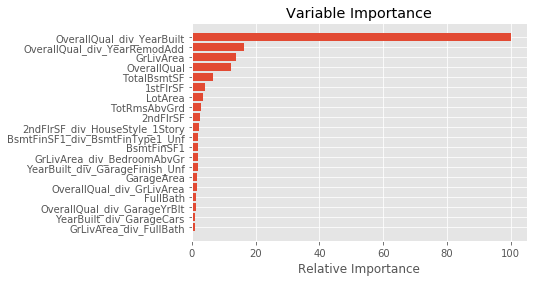

In [27]:
varImpPlot(rf, feature_cols_train, topN=20, verbose=False)

In [28]:
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_cols_ar = np.array(feature_cols_train)
new_feature_cols = feature_cols_ar[feature_importance > 0]

In [29]:
X1, X2, Y1, Y2 = \
 train_test_split(x_train[new_feature_cols], y_train, test_size=0.3, random_state=1234)

# train_test_split(x_train_sfeature[new_feature_cols], y_train_sfeature, test_size=0.3, random_state=1234)

In [30]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X1, Y1)
ypred = rf.predict(X2)

In [31]:
print("Root Means Square:", np.sqrt(mean_squared_error(y_true=Y2, y_pred=ypred)))

Root Means Square: 25632.445975


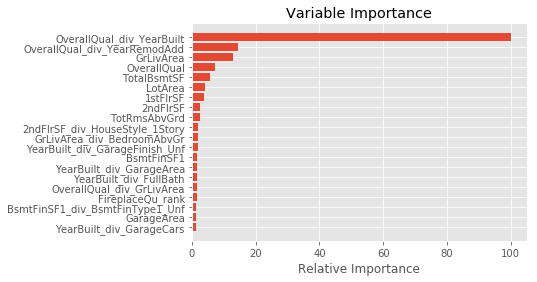

In [32]:
varImpPlot(rf, new_feature_cols, topN=20, verbose=False)

OverallQual：材料全体及び完成時の品質レベル

YearBuilt：建築年

KitchenQual_TA：キッチンの品質

GrLivArea：住居部分の面積

YearRemodAdd：リモデル年

TotalBsmtSF：敷地総面積

BsmtQual_TA：敷地の高さ

1stFlrSF：1階部分の面積

LotArea：駐車場面積

TotRmsAbvGrd：総部屋数

# 学習処理

In [65]:
#ターゲット変数と説明変数の設定
include_cols = ['']
#include_cols = ['OverallQual','YearBuilt','KitchenQual_TA','GrLivArea','YearRemodAdd','TotalBsmtSF','BsmtQual_TA','1stFlrSF','LotArea','TotRmsAbvGrd','2ndFlrSF','FlouseStyle_1Story','ExterQual_TA','BsmtFinSF1']
#include_cols = ['OverallQual','YearBuilt','KitchenQual_TA','GrLivArea','YearRemodAdd']
#include_cols = ['OverallQual_div_YearBuilt','OverallQual_div_KitchenQual_TA','GrLivArea','OverallQual_div_YearRemodAdd','OverallQual','TotalBsmtSF','OverallQual_div_BsmtQual_TA']
feature_cols = [col for col in x_train.columns if col in include_cols or col in x_train_origin_col]

#説明変数のデータ
x_train_sel = x_train[feature_cols]
x_train_sel.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


In [66]:
#学習データを、学習用とパラメータチューニング用に分割
X_train1, X_train2, Y_train1, Y_train2 = \
    train_test_split(x_train_sel, y_train, test_size=0.3, random_state=1234)

In [67]:
xb = xgb.XGBRegressor(max_depth=5,min_child_weight=1,gamma=0,subsample=0.2,colsample_bytree=0.2,learning_rate=0.1)
xb.fit(X_train1, Y_train1)
xb.score(X_train1, Y_train1)

0.95749788576438588

In [70]:
#モデルに伴う予測値
Y_pred1 = xb.predict(X_train1)
Y_pred2 = xb.predict(X_train2)

In [71]:
# MSEの計算
from sklearn.metrics import mean_squared_error
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(Y_train1, Y_pred1), mean_squared_error(Y_train2, Y_pred2)) )

# R^2の計算
from sklearn.metrics import r2_score
print('R^2 train : %.3f, test : %.3f' % (r2_score(Y_train1, Y_pred1), r2_score(Y_train2, Y_pred2)) )

MSE train : 291514852.956, test : 562794624.532
R^2 train : 0.957, test : 0.887


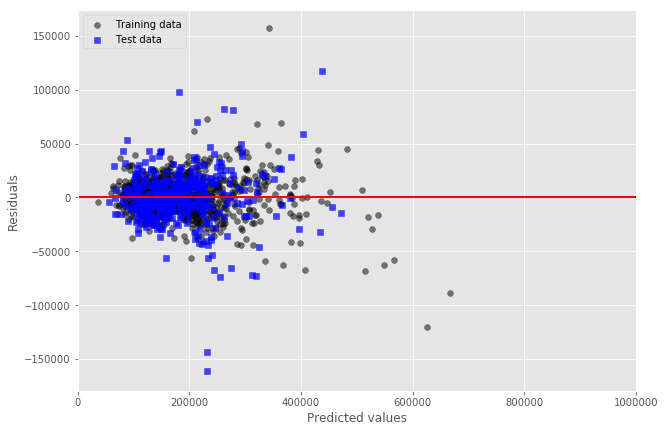

In [72]:
plt.figure(figsize = (10, 7))
plt.scatter(Y_pred1, Y_pred1 - Y_train1, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(Y_pred2, Y_pred2 - Y_train2, c = 'blue', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 1000000, lw = 2, color = 'red')
plt.xlim([0, 1000000])
plt.show()

# 予測処理

In [73]:
#x_test['OverallQual_div_YearBuilt'] = x_test['OverallQual']/(x_test['YearBuilt']+0.01)
#x_test['OverallQual_div_KitchenQual_TA'] = x_test['OverallQual']/(x_test['KitchenQual_TA']+0.01)
#x_test['OverallQual_div_YearRemodAdd'] = x_test['OverallQual']/(x_test['YearRemodAdd']+0.01)
#x_test['OverallQual_div_BsmtQual_TA'] = x_test['OverallQual']/(x_test['BsmtQual_TA']+0.01)

#include_cols = ['OverallQual_div_YearBuilt','OverallQual_div_KitchenQual_TA','GrLivArea','OverallQual_div_YearRemodAdd','OverallQual','TotalBsmtSF','OverallQual_div_BsmtQual_TA']
#feature_cols = [col for col in x_test.columns if col in include_cols]
feature_cols = [col for col in x_test.columns if col in x_train_sel.columns]

#説明変数のデータ
x_test_sel = x_test[feature_cols]
x_test_sel.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,0,1,0,0,0,1,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [74]:
#予測の実施
Y_pred = xb.predict(x_test_sel)

In [75]:
test_data['SalePrice'] = Y_pred

In [76]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,117904.398438
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,166369.171875
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,187880.312500
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,190346.218750
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,184974.843750


In [77]:
#データの書き出し
outfile = DataFrame({'Id': test_data['Id'], 'SalePrice': test_data['SalePrice']})
outfile.to_csv("submission.csv", index=False)

In [78]:
outfile.head()

,Id,SalePrice
0,1461,117904.398438
1,1462,166369.171875
2,1463,187880.312500
3,1464,190346.218750
4,1465,184974.843750
